In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

### Optimal graph search with broken bonds

In this note book we consider the local optimal solution if we are optimizing the total (average) dissipation when one of the edges (e.g., $e'$) is broken. For each set of conductivities with a cut bond, we can compute the node potential $\theta$ and subsequently obtain the dissipation $D_{e'}$. 

The key equations that are different to the basic case are: 

Relationship between the conductance and flow:

$$
k_{e}=\frac{\left(\left\langle F_{e}^{2}\right\rangle\right)^{\frac{1}{1+\gamma}}}{\left[\sum_{a \in E}\left(\left\langle F_{a}^{2}\right\rangle\right)^{\frac{\gamma}{1+\gamma}}\right]^{1 / \gamma}} K
$$

where

$$
\left\langle F_{e}^{2}\right\rangle=\frac{1}{n} \sum_{(e)}^{n} F_{e}^{e'^{\;2}}
$$



In [2]:
def hexagon_leaf(N):
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)
            
    return G

In [3]:
G = hexagon_leaf(6)

In [4]:
K = 1
gamma = 0.5 

def parameterize_leaf(N):
    
    'add transport netowrk variables'

    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)

    # add edge attr:
    nx.set_node_attributes(G, -1, 'P') # set node strength
    G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # set supply node strength
    nx.set_node_attributes(G, 0, 'theta') # initialize potentials, not important, will be the first thing to calculate
    nx.set_node_attributes(G, 'C0', 'color')

    # add node attr:
    nx.set_edge_attributes(G, 1/(G.number_of_nodes()**(1/gamma)), 'weight') # set initial capacity dist. to be uniform, use 'weight' instead of 'k' for easy access of laplacian matrix
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here


    return G

In [5]:
def parameterize_leaf_with_hydathode(N, strength = 2, hydathode = (2,1)):

    'add one node as hydathode that is a stronger sink, we keep the supply consistant'
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)

    # add edge attr, renormalize sinks: 
    re_norm = (G.number_of_nodes() - 1)/(G.number_of_nodes() - 2 + strength) 
    nx.set_node_attributes(G, -1*re_norm, 'P') # set node strength
    G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # keep supply consistent
    G.nodes[hydathode]['P'] = -strength*re_norm
    
    nx.set_node_attributes(G, 0, 'theta')

    nx.set_node_attributes(G, 'C0', 'color')
    G.nodes[hydathode]['color'] = 'C1'

    # add node attr:
    nx.set_edge_attributes(G, 1/(G.number_of_nodes()**(1/gamma)), 'weight') # uniform capacity 
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here


    return G

In [6]:
def two_hydathodes(N, strength = 10, hydathode_1= (2,1), hydathode_2 = (4,2)):

    'add one node as hydathode that is a stronger sink, we keep the supply consistant'
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)

    # add edge attr, renormalize sinks: 
    re_norm = (G.number_of_nodes() - 1)/(G.number_of_nodes() - 3 + strength*2) 
    nx.set_node_attributes(G, -1*re_norm, 'P') # set node strength
    G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # keep supply consistent
    G.nodes[hydathode_1]['P'] = -strength*re_norm
    G.nodes[hydathode_2]['P'] = -strength*re_norm
    
    nx.set_node_attributes(G, 0, 'theta')

    nx.set_node_attributes(G, 'C0', 'color')
    G.nodes[hydathode_1]['color'] = 'C1'
    G.nodes[hydathode_2]['color'] = 'C1'

    # add node attr:
    nx.set_edge_attributes(G, 1/(G.number_of_nodes()**(1/0.5)), 'weight') # uniform capacity 
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here


    return G

In [7]:
def plot_network(mesh):
    '''
    plot network with edge width proportional to sqrt of capacity, which can be seen as proportional to the diameter
    highlight hydathode color
    '''

    node_positions = {}
        
    for node in mesh.nodes:
        node_positions[node] = mesh.nodes[node]['pos']

    diam_list = [np.sqrt(mesh[u][v]['weight'])*100 for u,v in mesh.edges()]
    
    color_list =[ mesh.nodes[node]['color'] for node in mesh.nodes()]

    fig, ax = plt.subplots(figsize=(8,7))

    nx.draw(mesh, 
            with_labels = True,
            pos=node_positions, 
            node_size= 30,  
            node_color = color_list,
            width=diam_list,
            ax = ax) 

    plt.tight_layout()
    plt.show()   


In [8]:
def randomized_k(G):
    
    'start with a different capacity distribution'

    rand_list = np.random.randint(0,10000, G.number_of_edges())
    norm_list = rand_list/rand_list.sum()
    k_list = norm_list**(1/gamma)
    nx.set_edge_attributes(G, dict(zip(list(G.edges),k_list)), 'weight')

#### Plot the uniformly initialized network:


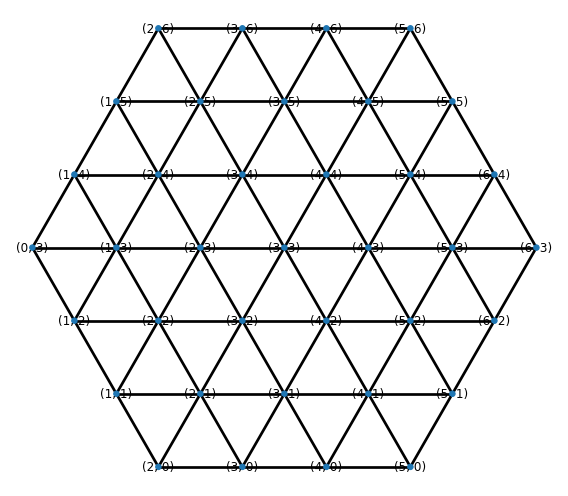

In [9]:
G = parameterize_leaf(6)
plot_network(G)

#### Plot the randomized network:

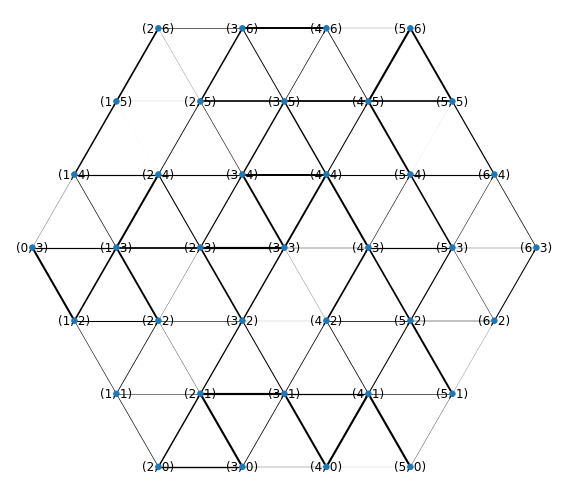

In [10]:
randomized_k(G)
plot_network(G)

### Relaxation functions for the basic model:

In [11]:
def solve_P_theta(G):
    
    L = nx.laplacian_matrix(G, nodelist=None, weight='weight')
    P_vec = [G.nodes[node]['P'] for node in G.nodes]
    theta_vec = np.linalg.solve(L.todense(), P_vec)
    nx.set_node_attributes(G, dict(zip(list(G.nodes),theta_vec)), 'theta')

    # positive flow: the direction is always toward the node with lower potential: 
    for e in G.edges:
        G[e[0]][e[1]]['F'] =  abs(G[e[0]][e[1]]['weight']*(G.nodes[e[0]]['theta'] - G.nodes[e[1]]['theta']))

In [12]:
# set a threshold to remove the edge: 
weight_lower = 1e-20 

def new_k(G):
    
    F_vec = np.array([G[e[0]][e[1]]['F']  for e in G.edges])
    F_scaling_sum = (((F_vec**2)**(gamma/(1+gamma))).sum())**(1/gamma)

    for e in G.edges:
        weight = (G[e[0]][e[1]]['F']**2)**(1/(1+gamma)) / F_scaling_sum
        if weight < weight_lower:
            G.remove_edge(*e)
        else:
            G[e[0]][e[1]]['weight'] = weight 

    # calculate dissipation:
    weight_vec = np.array([G[e[0]][e[1]]['weight']  for e in G.edges])
    F_vec = np.array([G[e[0]][e[1]]['F']  for e in G.edges]) # need to redefine here, since length might change due to edge drop

    G.graph['D'] = np.dot(F_vec**2, 1/weight_vec)
    
    

#### Run the relaxation for 30 iterations from uniform initialization:¶

In [13]:
G = parameterize_leaf(6)
for i in range(30):
    print('iteration:', i+1)
    solve_P_theta(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:',G.number_of_edges())
    print()

iteration: 1
dissipation D: 1525178.1835257036
number of edges left: 90

iteration: 2
dissipation D: 1078730.5254739742
number of edges left: 90

iteration: 3
dissipation D: 846849.0307496294
number of edges left: 90

iteration: 4
dissipation D: 799426.6652329685
number of edges left: 90

iteration: 5
dissipation D: 782015.6913418102
number of edges left: 88

iteration: 6
dissipation D: 765796.0387926828
number of edges left: 84

iteration: 7
dissipation D: 747803.7213165266
number of edges left: 78

iteration: 8
dissipation D: 728313.2824907748
number of edges left: 64

iteration: 9
dissipation D: 707843.4595829083
number of edges left: 60

iteration: 10
dissipation D: 686102.7397129982
number of edges left: 60

iteration: 11
dissipation D: 661885.5079397054
number of edges left: 60

iteration: 12
dissipation D: 634320.1321964597
number of edges left: 58

iteration: 13
dissipation D: 604787.1330056915
number of edges left: 54

iteration: 14
dissipation D: 576907.7115772531
number of e

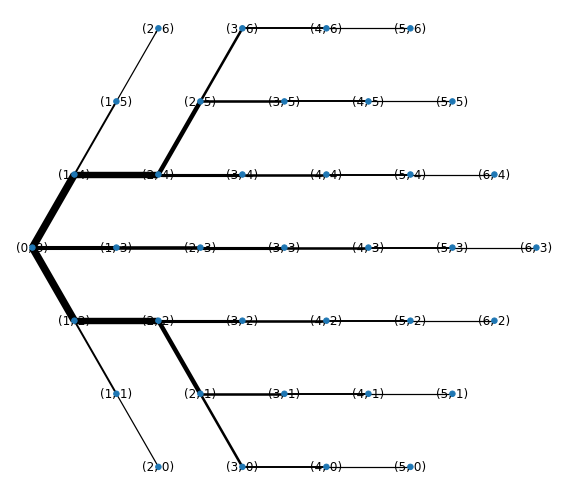

In [14]:
plot_network(G)

It does not look like the most optimized tree, where the biggest conductances are usually on the mid-rib.

#### Run relaxation for network with one bigger sink at node  $(2,1)$ , highlight in orange:

In [15]:
G_h= parameterize_leaf_with_hydathode(6,10)
for i in range(30):
    print('iteration:', i+1)
    solve_P_theta(G_h)
    new_k(G_h)
    print('dissipation D:', G_h.graph['D'])
    print('number of edges left:', G_h.number_of_edges())
    print()

iteration: 1
dissipation D: 1266764.8155386199
number of edges left: 90

iteration: 2
dissipation D: 892487.8432833368
number of edges left: 90

iteration: 3
dissipation D: 728490.6900006504
number of edges left: 90

iteration: 4
dissipation D: 691523.9194090449
number of edges left: 89

iteration: 5
dissipation D: 676615.8495111554
number of edges left: 87

iteration: 6
dissipation D: 664154.2514122415
number of edges left: 84

iteration: 7
dissipation D: 650735.8702920765
number of edges left: 73

iteration: 8
dissipation D: 636038.9637772115
number of edges left: 65

iteration: 9
dissipation D: 619958.9429374085
number of edges left: 60

iteration: 10
dissipation D: 602373.9934851768
number of edges left: 59

iteration: 11
dissipation D: 583673.4844524835
number of edges left: 58

iteration: 12
dissipation D: 564576.8826593453
number of edges left: 57

iteration: 13
dissipation D: 545163.3468947232
number of edges left: 56

iteration: 14
dissipation D: 525130.2919105177
number of ed

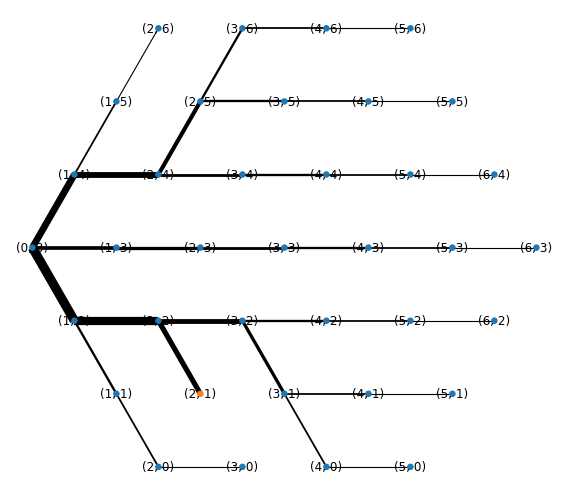

In [16]:
plot_network(G_h)

### Relaxation method for the broken bond model:

In [17]:
def solve_avearge_F(G):

    '''
    For each G - {e'} graph, we solve for the potential given the previous computed capacity, and the flow subsequently;
    The function returns the averaged flow over all G - {e'} graphs.
    Note that we solve for the least square solution, not exact, to prevent singular matrix inversion errors.
    '''
    # keep a total flow dic:
    edge_list = list(G.edges())
    flow_list = [0]*G.number_of_edges()
    F_tot = dict(zip(edge_list, flow_list))
    
    for a, b in G.edges:
 
        # make broken edge copy: 
        G_ab = G.copy()
        G_ab.remove_edge(a, b)
        # get the laplacian:
        L = nx.laplacian_matrix(G_ab, nodelist=None, weight='weight')   
        P_vec = [G_ab.nodes[node]['P'] for node in G_ab.nodes]
        # solve for least square node potentials:
        leastsq = np.linalg.lstsq(L.todense(), P_vec, rcond = None)
        theta_vec = leastsq[0]
        nx.set_node_attributes(G_ab, dict(zip(list(G_ab.nodes),theta_vec)), 'theta')
        for u, v in G_ab.edges:
            F_tot[(u,v)] += abs(G_ab[u][v]['weight']*(G_ab.nodes[u]['theta'] - G_ab.nodes[v]['theta']))

    # averaging flow for the edges over all broken edge graphs: 
    for u, v in G.edges:
        G[u][v]['F'] = F_tot[(u,v)]/G.number_of_edges()

The other function `new_k()` is shared with the basic model.

iteration: 1
dissipation D: 1540078.4026091993
number of edges left: 90
iteration: 2
dissipation D: 1099822.0520614928
number of edges left: 90
iteration: 3
dissipation D: 879564.5044902011
number of edges left: 90
iteration: 4
dissipation D: 829392.3440874541
number of edges left: 90
iteration: 5
dissipation D: 812958.1814921352
number of edges left: 90
iteration: 6
dissipation D: 801814.9017347042
number of edges left: 88
iteration: 7
dissipation D: 791245.6370699708
number of edges left: 82
iteration: 8
dissipation D: 780526.9503880944
number of edges left: 76
iteration: 9
dissipation D: 768413.1938849642
number of edges left: 72
iteration: 10
dissipation D: 753506.6522892814
number of edges left: 68
iteration: 11
dissipation D: 735983.2371309907
number of edges left: 66
iteration: 12
dissipation D: 715339.4152809614
number of edges left: 66
iteration: 13
dissipation D: 694086.746404453
number of edges left: 62
iteration: 14
dissipation D: 679304.9899621458
number of edges left: 62


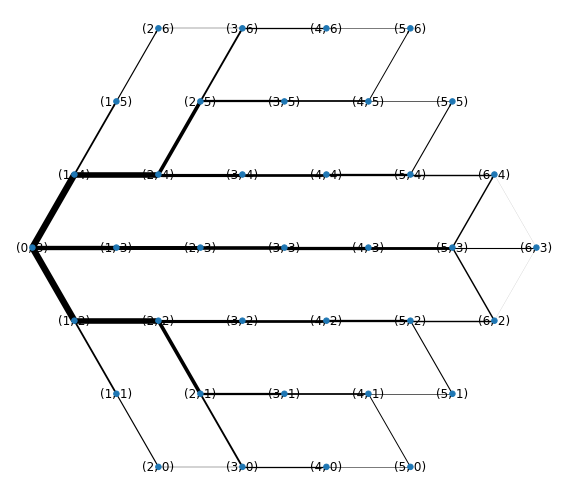

In [18]:
G = parameterize_leaf(6)

for i in range(50):
    print('iteration:', i+1)
    solve_avearge_F(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:', G.number_of_edges())
plot_network(G)

#### try a randomly initialized graph:

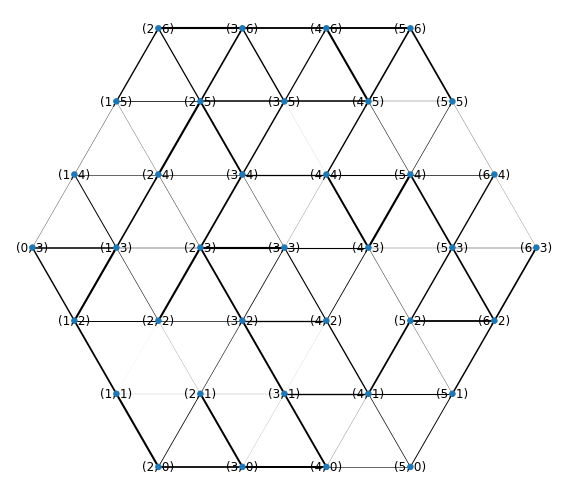

iteration: 1
dissipation D: 1430227.5605827507
number of edges left: 90
iteration: 2
dissipation D: 1121657.7445103703
number of edges left: 90
iteration: 3
dissipation D: 1015431.500947905
number of edges left: 90
iteration: 4
dissipation D: 935338.7089368145
number of edges left: 90
iteration: 5
dissipation D: 857442.5589655323
number of edges left: 87
iteration: 6
dissipation D: 786377.3257743835
number of edges left: 86
iteration: 7
dissipation D: 754805.5744453087
number of edges left: 82
iteration: 8
dissipation D: 742022.4695639557
number of edges left: 80
iteration: 9
dissipation D: 733640.605338078
number of edges left: 74
iteration: 10
dissipation D: 728811.7841059107
number of edges left: 69
iteration: 11
dissipation D: 724033.4666735464
number of edges left: 68
iteration: 12
dissipation D: 716843.0672944458
number of edges left: 66
iteration: 13
dissipation D: 712080.942912707
number of edges left: 62
iteration: 14
dissipation D: 711639.0324819986
number of edges left: 60
i

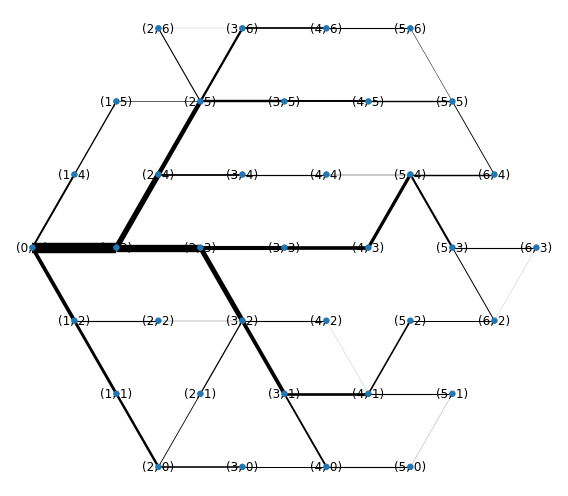

In [19]:
G = parameterize_leaf(6)
randomized_k(G)
plot_network(G)
for i in range(50):
    print('iteration:', i+1)
    solve_avearge_F(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:', G.number_of_edges())
plot_network(G)

#### Try adding conditions for a hydathode:

iteration: 1
dissipation D: 1288189.7902354528
number of edges left: 90
iteration: 2
dissipation D: 912802.3642098113
number of edges left: 90
iteration: 3
dissipation D: 752891.1465788921
number of edges left: 90
iteration: 4
dissipation D: 713159.1238974559
number of edges left: 90
iteration: 5
dissipation D: 698926.2495552066
number of edges left: 90
iteration: 6
dissipation D: 689320.1297630626
number of edges left: 87
iteration: 7
dissipation D: 680100.4812353291
number of edges left: 81
iteration: 8
dissipation D: 670487.7532707427
number of edges left: 73
iteration: 9
dissipation D: 660441.3239748873
number of edges left: 68
iteration: 10
dissipation D: 648746.5872665085
number of edges left: 66
iteration: 11
dissipation D: 635041.5032606233
number of edges left: 64
iteration: 12
dissipation D: 620904.3494820297
number of edges left: 63
iteration: 13
dissipation D: 606953.5056669809
number of edges left: 62
iteration: 14
dissipation D: 594762.8576543068
number of edges left: 62


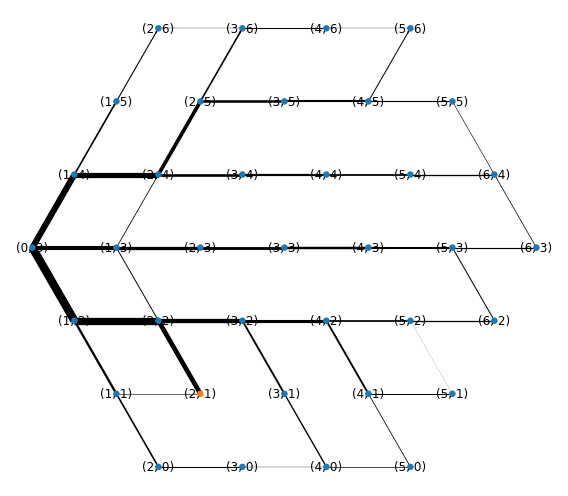

In [20]:
G = parameterize_leaf_with_hydathode(6, strength= 10, hydathode = (2,1))
for i in range(50):
    print('iteration:', i+1)
    solve_avearge_F(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:', G.number_of_edges())
plot_network(G)

#### Adding conditions for 2 hydathodes:

iteration: 1
dissipation D: 1625656.0808484447
number of edges left: 90
iteration: 2
dissipation D: 1072490.4225918178
number of edges left: 90
iteration: 3
dissipation D: 861810.2683811949
number of edges left: 90
iteration: 4
dissipation D: 801398.6937519022
number of edges left: 90
iteration: 5
dissipation D: 779506.0194723648
number of edges left: 90
iteration: 6
dissipation D: 768600.5857005465
number of edges left: 87
iteration: 7
dissipation D: 760217.9106272531
number of edges left: 81
iteration: 8
dissipation D: 751308.4161417328
number of edges left: 77
iteration: 9
dissipation D: 740005.3613503855
number of edges left: 71
iteration: 10
dissipation D: 727119.7661165623
number of edges left: 68
iteration: 11
dissipation D: 711774.3290042293
number of edges left: 65
iteration: 12
dissipation D: 695147.100760235
number of edges left: 61
iteration: 13
dissipation D: 679044.3839587005
number of edges left: 61
iteration: 14
dissipation D: 662602.9813061343
number of edges left: 60


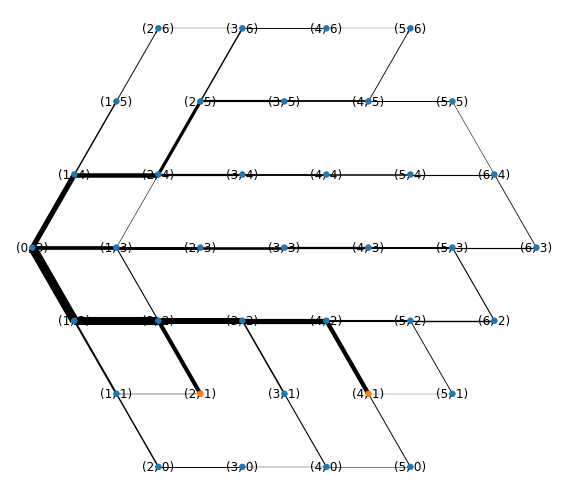

In [29]:
G = two_hydathodes(6, strength = 10, hydathode_1=(2,1), hydathode_2=(4,1))
for i in range(50):
    print('iteration:', i+1)
    solve_avearge_F(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:', G.number_of_edges())
plot_network(G)